In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib.pyplot import subplots
import joblib

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [13]:
root_dir = 'C:/Users/elmow/Documents/Kaggle/Dog_Classification/data/train'
csv_file = 'C:/Users/elmow\Documents/Kaggle/Dog_Classification/data/labels.csv'

In [14]:
#Hyperparameters
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2
BATCH_SIZE = 64

In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.loc[idx, "id"] + ".jpg")
        image = Image.open(img_name)
        label_int = torch.tensor(self.data.loc[idx, "breed"], dtype=torch.long)
        # one_hot_label = torch.zeros(self.num_classes)
        # one_hot_label[label_int] = 1
        if self.transform:
            image = self.transform(image)
        return image, label_int

labels_df = pd.read_csv(csv_file)
num_classes = labels_df['breed'].nunique()

# Create a label encoder object
#class_encoder
mapping = {}
inverse_mapping = {}
for i, c in enumerate(labels_df['breed'].unique()):
    mapping[c] = i
    inverse_mapping[i] = c

# Fit and transform the 'breed' column to get integer labels
for i in range(labels_df.shape[0]):
    labels_df.loc[i, 'breed'] = mapping[labels_df.loc[i, 'breed']]

#Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet normalization
])

#Datasets
dataset = CustomImageDataset(root_dir=root_dir, csv_file=labels_df, transform=transform)
total_samples = len(dataset)
train_size = TRAIN_SIZE
test_size = TEST_SIZE
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,0
1,001513dfcb2ffafc82cccf4d8bbaba97,1
2,001cdf01b096e06d78e9e5112d419397,2
3,00214f311d5d2247d5dfe4fe24b2303d,3
4,0021f9ceb3235effd7fcde7f7538ed62,4


In [6]:
#Resnet
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\elmow\Documents\Kaggle\Dog_Classification\dbcl_main\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\elmow\Documents\Kaggle\Dog_Classification\dbcl_main\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
#Trainning Loop
num_epochs = 10
errors_list = []
for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss_val = criterion(outputs, labels)
        loss_val.backward()
        optimizer.step()

        running_train_loss += loss_val.item()

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            
            running_test_loss += loss_val.item()

    avg_train_loss = running_train_loss / len(train_loader)
    avg_test_loss = running_test_loss / len(test_loader)
    
    errors_list.append({'test_loss': avg_test_loss, 'train_loss': avg_train_loss})

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss}, Test_Loss: {avg_test_loss}")

Epoch 1/10, Loss: 4.270410753786564, Test_Loss: 3.4613116830587387
Epoch 2/10, Loss: 2.862501511350274, Test_Loss: 2.4358492121100426
Epoch 3/10, Loss: 2.0035327468067408, Test_Loss: 1.863207172602415
Epoch 4/10, Loss: 1.5291337398812175, Test_Loss: 1.5540472008287907
Epoch 5/10, Loss: 1.229102499783039, Test_Loss: 1.3647903464734554
Epoch 6/10, Loss: 1.0167517592199147, Test_Loss: 1.2438203319907188
Epoch 7/10, Loss: 0.8637261111289263, Test_Loss: 1.1555025912821293
Epoch 8/10, Loss: 0.7331076734699309, Test_Loss: 1.1000642701983452
Epoch 9/10, Loss: 0.627453352091834, Test_Loss: 1.0552043989300728
Epoch 10/10, Loss: 0.5410001310519874, Test_Loss: 1.0243001691997051


In [8]:
errors = pd.DataFrame(errors_list)
errors

,test_loss,train_loss
0,3.461312,4.270411
1,2.435849,2.862502
2,1.863207,2.003533
3,1.554047,1.529134
4,1.364790,1.229102
5,1.243820,1.016752
6,1.155503,0.863726
7,1.100064,0.733108
8,1.055204,0.627453
9,1.024300,0.541000


Text(0, 0.5, 'Loss')

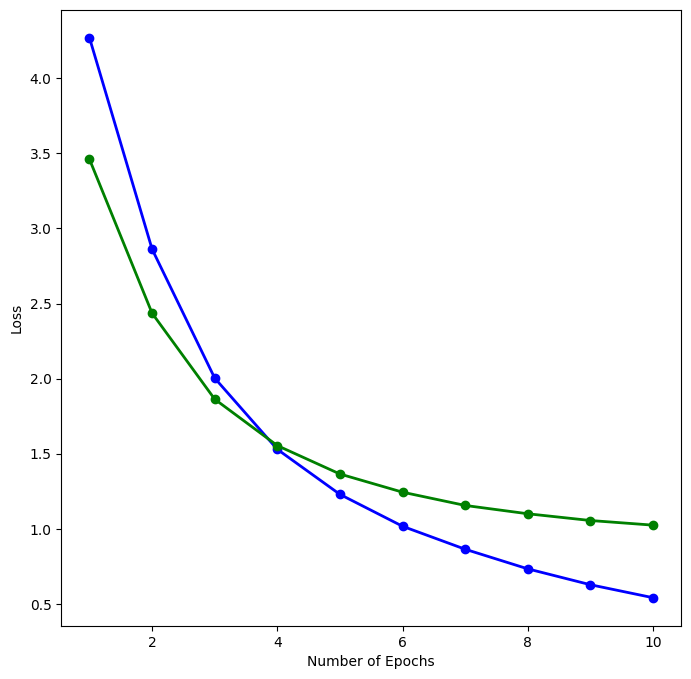

In [9]:
fig, ax = subplots(figsize=(8,8))
ax.plot([i + 1 for i in range(errors.shape[0])],errors['train_loss'], color='blue', marker='o', linewidth=2)
ax.plot([i + 1 for i in range(errors.shape[0])],errors['test_loss'], color='green', marker='o', linewidth=2)
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")



In [10]:
torch.save(model.state_dict(), 'saved_param/ResNet.pth')

In [11]:
model.load_state_dict(torch.load('saved_param/ResNet.pth'))
model.eval();

In [12]:
def predict(model, input):
    with torch.no_grad():
        output = model(input)
        probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities

In [14]:
image, label = dataset[0]
image = image.unsqueeze(0)
image = image.to(device)

In [42]:
submission = pd.DataFrame()

for root, dirs, files in os.walk("test"):
    for filename in files:
        image_path = os.path.join('test/', filename)
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)
        prediction = predict(model, image).squeeze()
        img_data = {'id': filename[:-4]}
        
        for i in range(len(prediction)):
            img_data[inverse_mapping[i]] = prediction[i].item()
        img_df = pd.DataFrame([img_data])
        submission = pd.concat([submission, img_df], ignore_index=True)


In [43]:
submission.head()

,id,boston_bull,dingo,pekinese,bluetick,golden_retriever,bedlington_terrier,borzoi,basenji,scottish_deerhound,...,blenheim_spaniel,silky_terrier,sussex_spaniel,german_short-haired_pointer,french_bulldog,bouvier_des_flandres,tibetan_mastiff,english_springer,cocker_spaniel,rottweiler
0,000621fb3cbb32d8935728e48679680e,0.000492,0.000129,0.168997,0.000087,0.000785,0.000057,0.001942,0.000097,0.000047,...,0.023586,0.000375,0.000130,0.000060,0.000609,0.000040,0.000305,0.000468,0.002406,0.000091
1,00102ee9d8eb90812350685311fe5890,0.000006,0.000169,0.000313,0.000019,0.000257,0.000042,0.000069,0.000012,0.000012,...,0.000007,0.000003,0.000005,0.000006,0.000060,0.000024,0.000290,0.000008,0.000009,0.000027
2,0012a730dfa437f5f3613fb75efcd4ce,0.000031,0.000015,0.000039,0.001563,0.000974,0.000466,0.004111,0.000007,0.000432,...,0.000845,0.000125,0.002343,0.002843,0.000039,0.000018,0.000073,0.004639,0.019630,0.000035
3,001510bc8570bbeee98c8d80c8a95ec1,0.007238,0.000552,0.007647,0.001750,0.003308,0.000474,0.000651,0.001742,0.002608,...,0.002239,0.004459,0.024236,0.007638,0.026968,0.009021,0.006746,0.004630,0.005093,0.007017
4,001a5f3114548acdefa3d4da05474c2e,0.000252,0.000028,0.006931,0.000091,0.000169,0.000086,0.000089,0.000080,0.000321,...,0.000567,0.008984,0.001860,0.000041,0.000633,0.005169,0.000704,0.000153,0.000535,0.000195


In [45]:
submission.to_csv('submissionResNet.csv', index=False)